# **Stock Price Forecasting Using LSTM and GRU**

# **Introduction**

In [87]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
#from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import warnings
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# **Importing Data**

Getting the Amazon stock data from yahoo financial API 

In [88]:
!pip install yahoofinancials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [89]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
AMZN = yf.download('AMZN', 
                      start='2013-01-01', 
                      end='2022-08-09', 
                      progress=False)
# AMZN = yf.download('AMZN') for all 
all_data = AMZN[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)


In [90]:
all_data.head()

Adj Close   Open   High    Low  Close    Volume
Date                                                       
2013-01-02      12.87  12.80  12.90  12.66  12.87  65420000
2013-01-03      12.92  12.86  13.04  12.82  12.92  55018000
2013-01-04      12.96  12.88  12.99  12.83  12.96  37484000
2013-01-07      13.42  13.15  13.49  13.13  13.42  98200000
2013-01-08      13.32  13.35  13.45  13.18  13.32  60214000

In [91]:
all_data.tail()

Adj Close    Open    High     Low   Close    Volume
Date                                                           
2022-08-02     134.16  134.72  137.44  134.09  134.16  61922400
2022-08-03     139.52  136.21  140.49  136.05  139.52  71827800
2022-08-04     142.57  140.58  143.56  139.55  142.57  70585000
2022-08-05     140.80  140.10  142.86  139.60  140.80  50686900
2022-08-08     139.41  142.05  144.23  138.29  139.41  52229000

### **Let's Understand more about the data.**

In [92]:
all_data.to_csv('stock_data.csv')

In [93]:
all_data.head(10)

Adj Close   Open   High    Low  Close    Volume
Date                                                       
2013-01-02      12.87  12.80  12.90  12.66  12.87  65420000
2013-01-03      12.92  12.86  13.04  12.82  12.92  55018000
2013-01-04      12.96  12.88  12.99  12.83  12.96  37484000
2013-01-07      13.42  13.15  13.49  13.13  13.42  98200000
2013-01-08      13.32  13.35  13.45  13.18  13.32  60214000
2013-01-09      13.32  13.41  13.48  13.27  13.32  45312000
2013-01-10      13.27  13.43  13.44  13.11  13.27  57268000
2013-01-11      13.40  13.26  13.42  13.21  13.40  48266000
2013-01-14      13.64  13.40  13.71  13.38  13.64  85500000
2013-01-15      13.60  13.53  13.64  13.47  13.60  46538000

In [ ]:
all_data.tail()

Adj Close    Open    High     Low   Close    Volume
Date                                                           
2022-08-02     134.16  134.72  137.44  134.09  134.16  61922400
2022-08-03     139.52  136.21  140.49  136.05  139.52  71827800
2022-08-04     142.57  140.58  143.56  139.55  142.57  70585000
2022-08-05     140.80  140.10  142.86  139.60  140.80  50686900
2022-08-08     139.41  142.05  144.23  138.29  139.41  52229000

# **EXploratory Data Analysis (EDA)**

In [94]:
all_data.shape

(2417, 6)

In [95]:
all_data.columns

Index(['Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

#### **Let's Understand More About The Data**

In [96]:
all_data.duplicated()

Date
2013-01-02    False
2013-01-03    False
2013-01-04    False
2013-01-07    False
2013-01-08    False
              ...  
2022-08-02    False
2022-08-03    False
2022-08-04    False
2022-08-05    False
2022-08-08    False
Length: 2417, dtype: bool

In [97]:
all_data.duplicated().sum()

0

In [98]:
#Getting all the columns
print("Features of the dataset:")
all_data.columns

Features of the dataset:


Index(['Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [99]:
#check details about the data set
print('Here is the information regarding the dataset :')
all_data.info()

Here is the information regarding the dataset :
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2417 entries, 2013-01-02 to 2022-08-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2417 non-null   float64
 1   Open       2417 non-null   float64
 2   High       2417 non-null   float64
 3   Low        2417 non-null   float64
 4   Close      2417 non-null   float64
 5   Volume     2417 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 132.2 KB


In [100]:
#print the unique value
print('Here is the unique values in our dataset')
all_data.nunique()

Here is the unique values in our dataset


Adj Close    2041
Open         1999
High         2037
Low          2069
Close        2041
Volume       2370
dtype: int64

In [101]:
#printign the data types of our data
print('Here is the data types of the dataset :')
all_data.dtypes

Here is the data types of the dataset :


Adj Close    float64
Open         float64
High         float64
Low          float64
Close        float64
Volume         int64
dtype: object

In [102]:
#Looking for the description of the dataset to get insights of the data
all_data.describe(include='all').T

count          mean           std          min          25%  \
Adj Close  2417.0  7.225407e+01  5.372190e+01        12.41        21.49   
Open       2417.0  7.228448e+01  5.377292e+01        12.45        21.49   
High       2417.0  7.308940e+01  5.442133e+01        12.65        21.65   
Low        2417.0  7.139028e+01  5.305112e+01        12.29        21.31   
Close      2417.0  7.225407e+01  5.372190e+01        12.41        21.49   
Volume     2417.0  8.069699e+07  4.264758e+07  17626000.00  53768000.00   

                   50%          75%           max  
Adj Close        51.28       100.65  1.865700e+02  
Open             51.06       101.28  1.872000e+02  
High             51.58       102.02  1.886500e+02  
Low              50.55       100.18  1.848400e+02  
Close            51.28       100.65  1.865700e+02  
Volume     69110000.00  93544000.00  4.771220e+08

In [103]:
#check for count of missing values in each column.
print('Here are the details of missing value details in our dataet:')
all_data.isna().sum()
all_data.isnull().sum()

Here are the details of missing value details in our dataet:


Adj Close    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64

<Axes: xlabel='Date'>

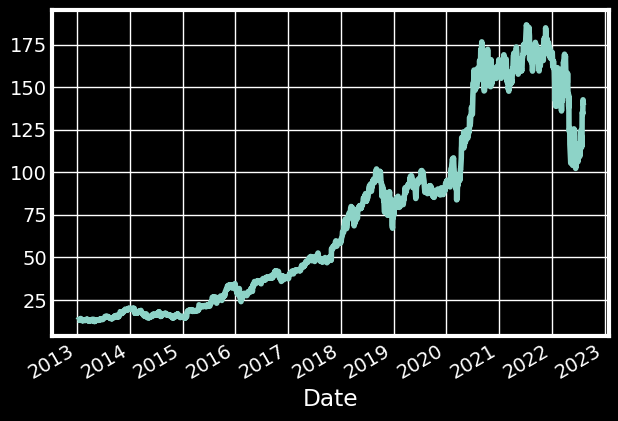

In [104]:
all_data['Close'].plot()

<Axes: xlabel='Date'>

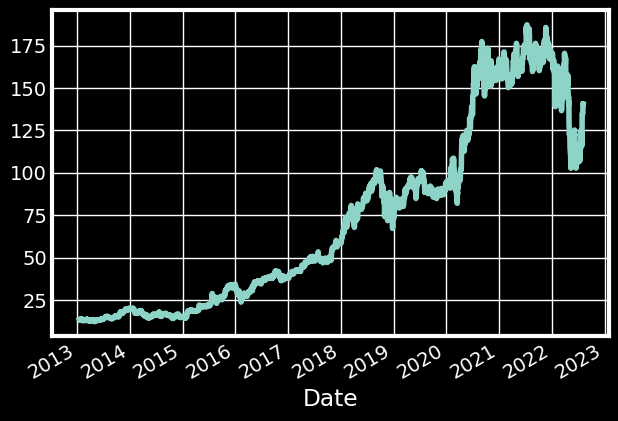

In [105]:
all_data['Open'].plot()

<Axes: xlabel='Date'>

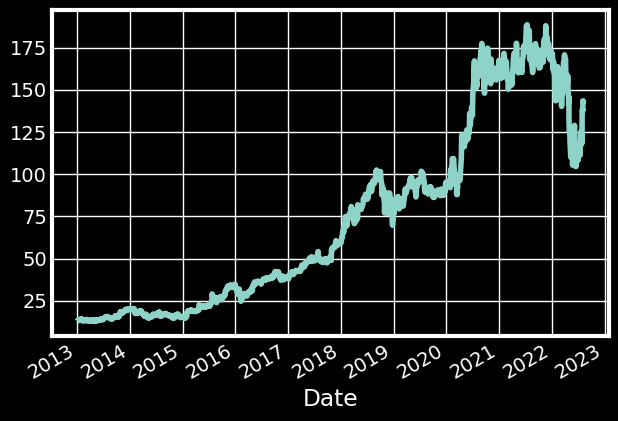

In [106]:
all_data['High'].plot()

<Axes: xlabel='Date'>

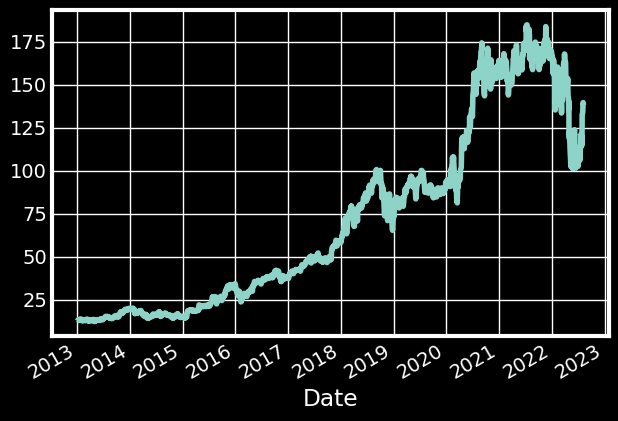

In [107]:
all_data['Low'].plot()

<Axes: xlabel='Date'>

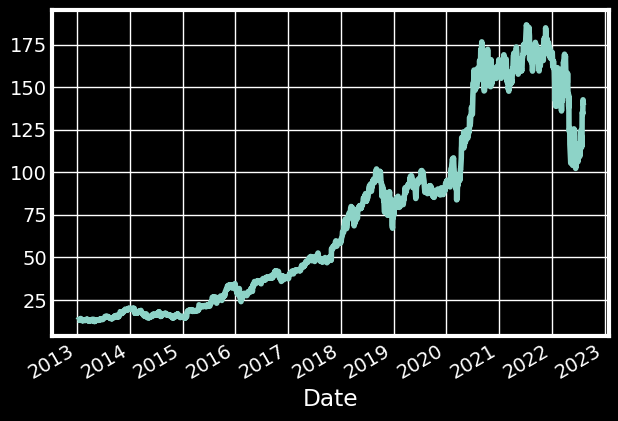

In [108]:
all_data['Adj Close'].plot()

<Axes: xlabel='Open', ylabel='count'>

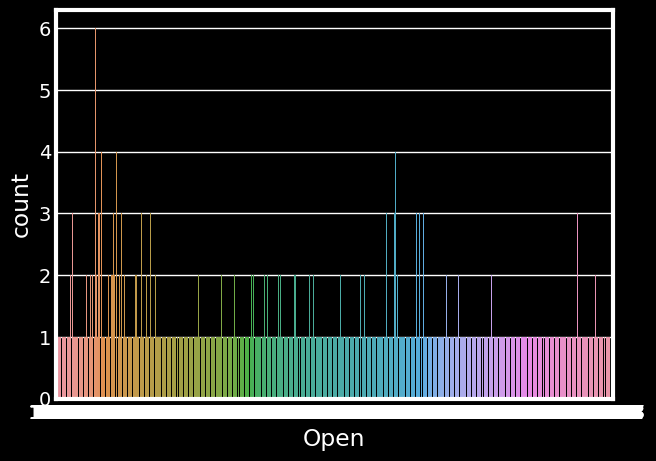

In [109]:
sns.countplot(x=all_data.Open)

In [110]:
data = pd.read_csv('stock_data.csv')

In [111]:
data.head()

Date  Adj Close   Open   High    Low  Close    Volume
0  2013-01-02      12.87  12.80  12.90  12.66  12.87  65420000
1  2013-01-03      12.92  12.86  13.04  12.82  12.92  55018000
2  2013-01-04      12.96  12.88  12.99  12.83  12.96  37484000
3  2013-01-07      13.42  13.15  13.49  13.13  13.42  98200000
4  2013-01-08      13.32  13.35  13.45  13.18  13.32  60214000

#### **Seasonality Plot for each column in our data**

In [112]:
from statsmodels.tsa.seasonal import seasonal_decompose

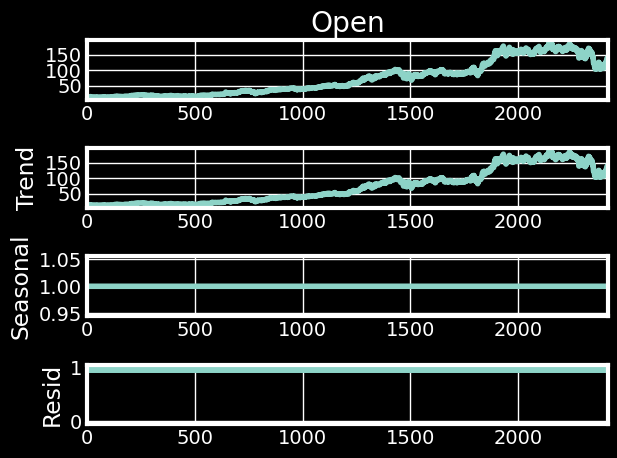

In [113]:
decompose_result = seasonal_decompose(data.Open, model='multiplicative', period=1)
decompose_result.plot();

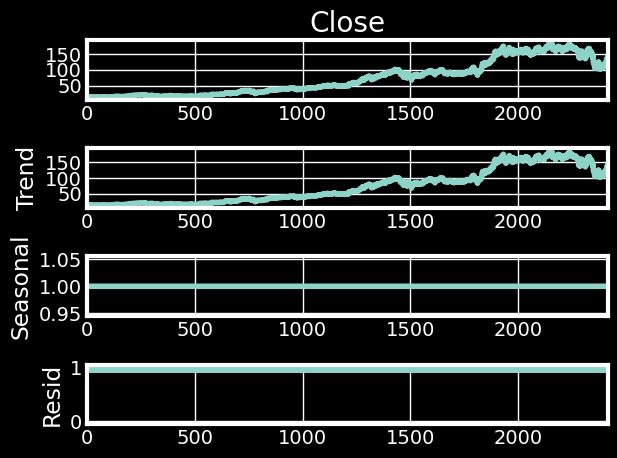

In [114]:
decompose_result = seasonal_decompose(data.Close, model='multiplicative', period=1)
decompose_result.plot();

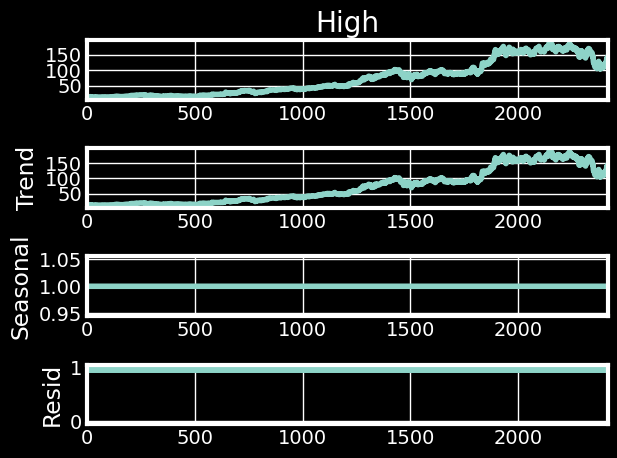

In [115]:
decompose_result = seasonal_decompose(data.High, model='multiplicative', period=1)
decompose_result.plot();

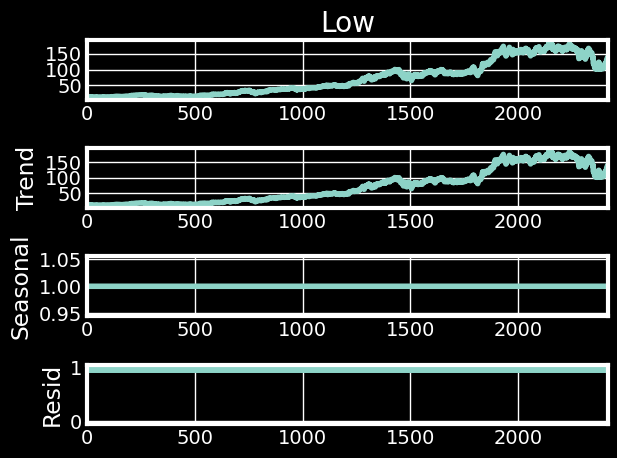

In [116]:
decompose_result = seasonal_decompose(data.Low, model='multiplicative', period=1)
decompose_result.plot();

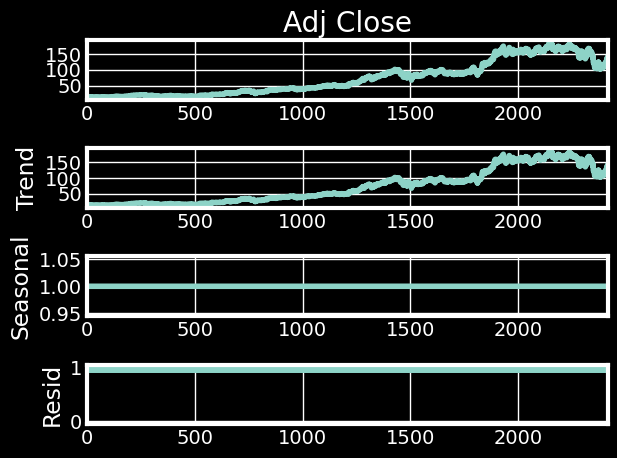

In [117]:
decompose_result = seasonal_decompose(data['Adj Close'], model='multiplicative', period=1)
decompose_result.plot();

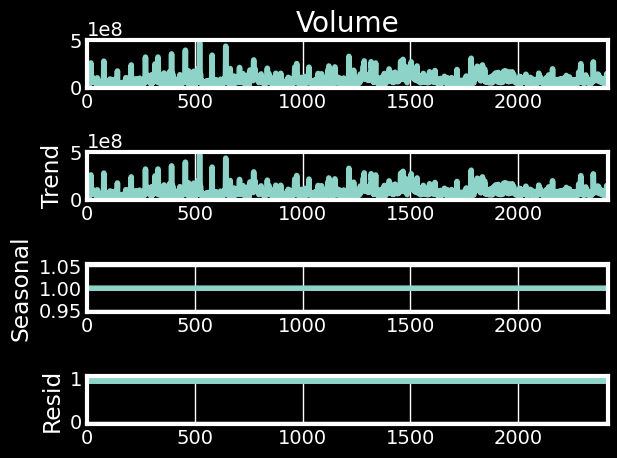

In [118]:
decompose_result = seasonal_decompose(data['Volume'], model='multiplicative', period=1)
decompose_result.plot();

**As We can see from the above there is no seasonality in our data.**

### **Distribution Plot**

<ipython-input-119-6ce5956e60b6>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




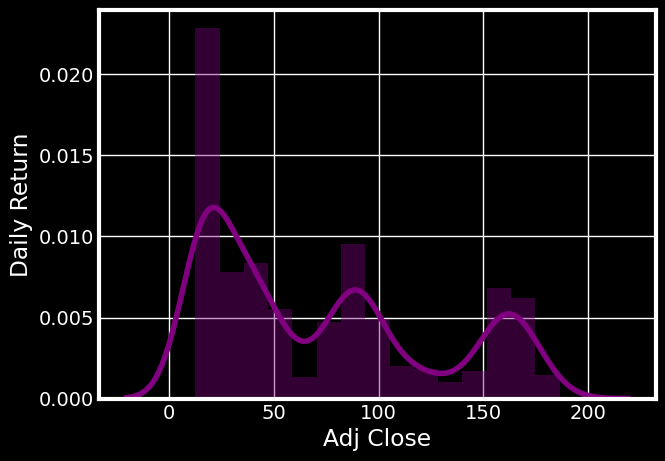

In [119]:
sns.distplot(data['Adj Close'].dropna(), color='purple');
plt.ylabel('Daily Return');

<ipython-input-120-a9fde1a80a1b>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: ylabel='Density'>

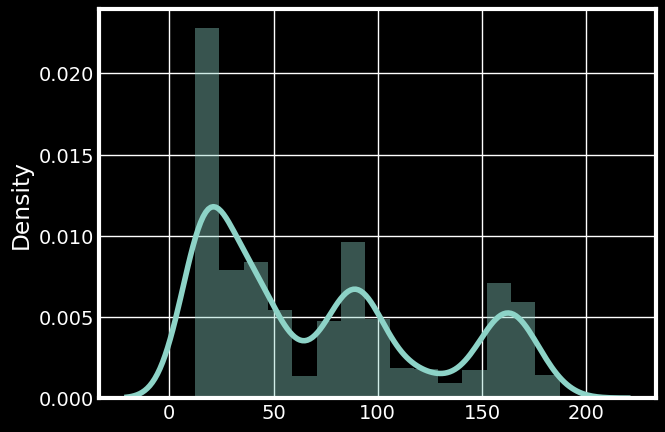

In [120]:
sns.distplot(x=all_data.Open)

<ipython-input-121-7f0393e5b26d>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: ylabel='Density'>

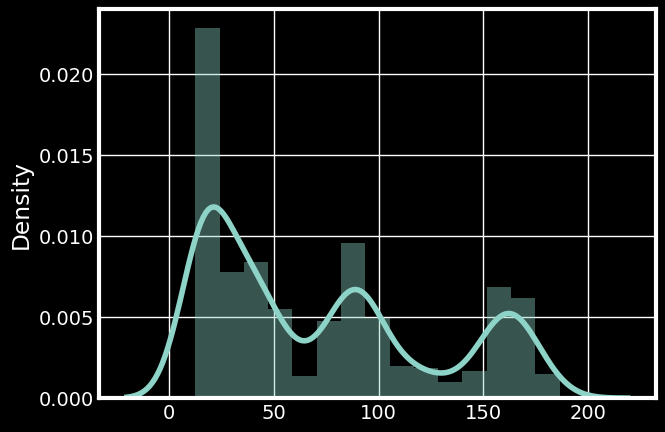

In [121]:
sns.distplot(x=all_data.Close)

<ipython-input-122-0e4e5f87f3fb>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: ylabel='Density'>

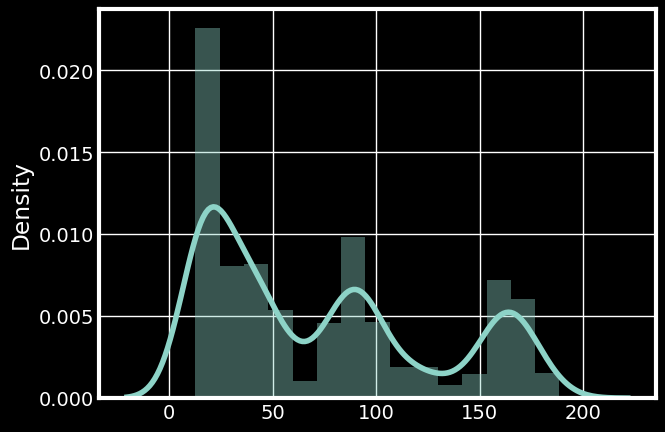

In [122]:
sns.distplot(x=all_data.High)

<ipython-input-123-7f0393e5b26d>:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: ylabel='Density'>

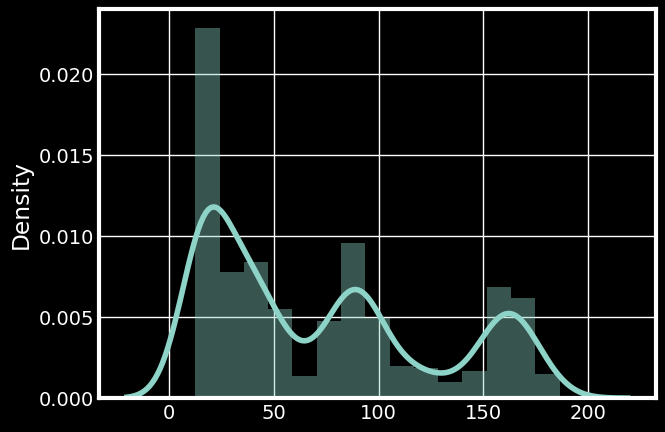

In [123]:
sns.distplot(x=all_data.Close)

In [124]:
data.columns, data.head()

(Index(['Date', 'Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object'),
          Date  Adj Close   Open   High    Low  Close    Volume
 0  2013-01-02      12.87  12.80  12.90  12.66  12.87  65420000
 1  2013-01-03      12.92  12.86  13.04  12.82  12.92  55018000
 2  2013-01-04      12.96  12.88  12.99  12.83  12.96  37484000
 3  2013-01-07      13.42  13.15  13.49  13.13  13.42  98200000
 4  2013-01-08      13.32  13.35  13.45  13.18  13.32  60214000)

### **Line Plots**

In [125]:
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
plt.style.use('fivethirtyeight')
plt.style.use('dark_background')

In [126]:
fig = px.line(data,x = 'Date', y = ['High', 'Low'], template = 'plotly_dark')
fig.show()

In [127]:
fig = px.line(data,x = 'Date', y = ['Open', 'Close'], template = 'plotly_dark')
fig.show()

In [128]:
fig = px.line(data,x = 'Date', y = ['Adj Close'], template = 'plotly_dark')
fig.show()

**From above plots we can conclude that:**

**1. High - Increases over time**

**2. Low - Increases over time**

**3. Open - Increases over time**

**4. Close - Increases over time**

In [129]:
fig = px.line(data,x = 'Date', y = ['Volume'], template = 'plotly_dark')
fig.show()

**From above plot we can conclude that : Volume doesn't increase gradually but have non-linear decrement**

### **Candle Stick Plot**

In [130]:
fig = go.Figure(data=[go.Candlestick(x=data['Date'],
                open=data['Open'],
                high=data['High'],
                low=data['Low'],
                close=data['Close'] ,increasing_line_color= 'cyan', decreasing_line_color= 'gray')])

fig.show()

**From above plot we can conclude that:Amazon's Stock increases over time and then have sudden shift in its increment**

### **Joint Plot**

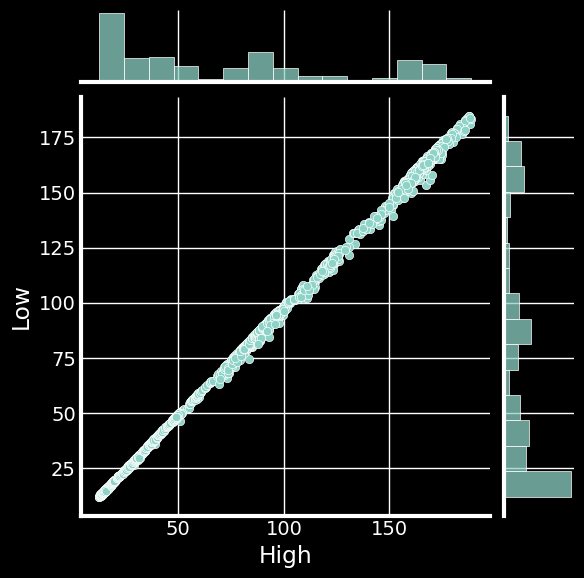

In [131]:
sns.jointplot(x ='High', y='Low', data = all_data);

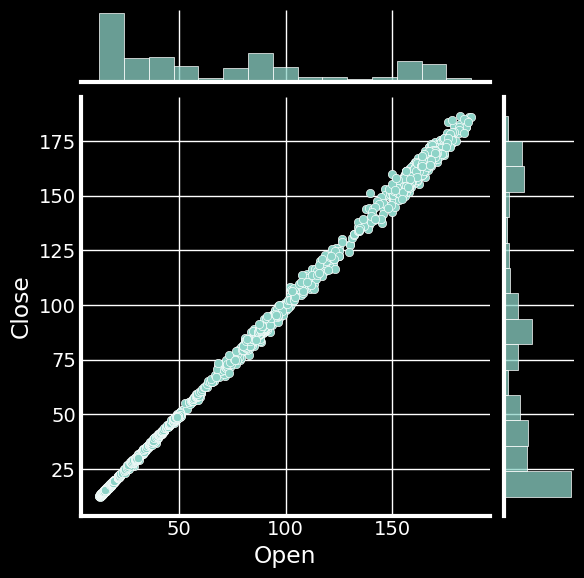

In [132]:
sns.jointplot(x='Open', y='Close', data=all_data);

**From above plot we can conclude that:**


**1. High and low are linarly dependent**


**2. Open and close are linearly dependent**

### **Pairplot**

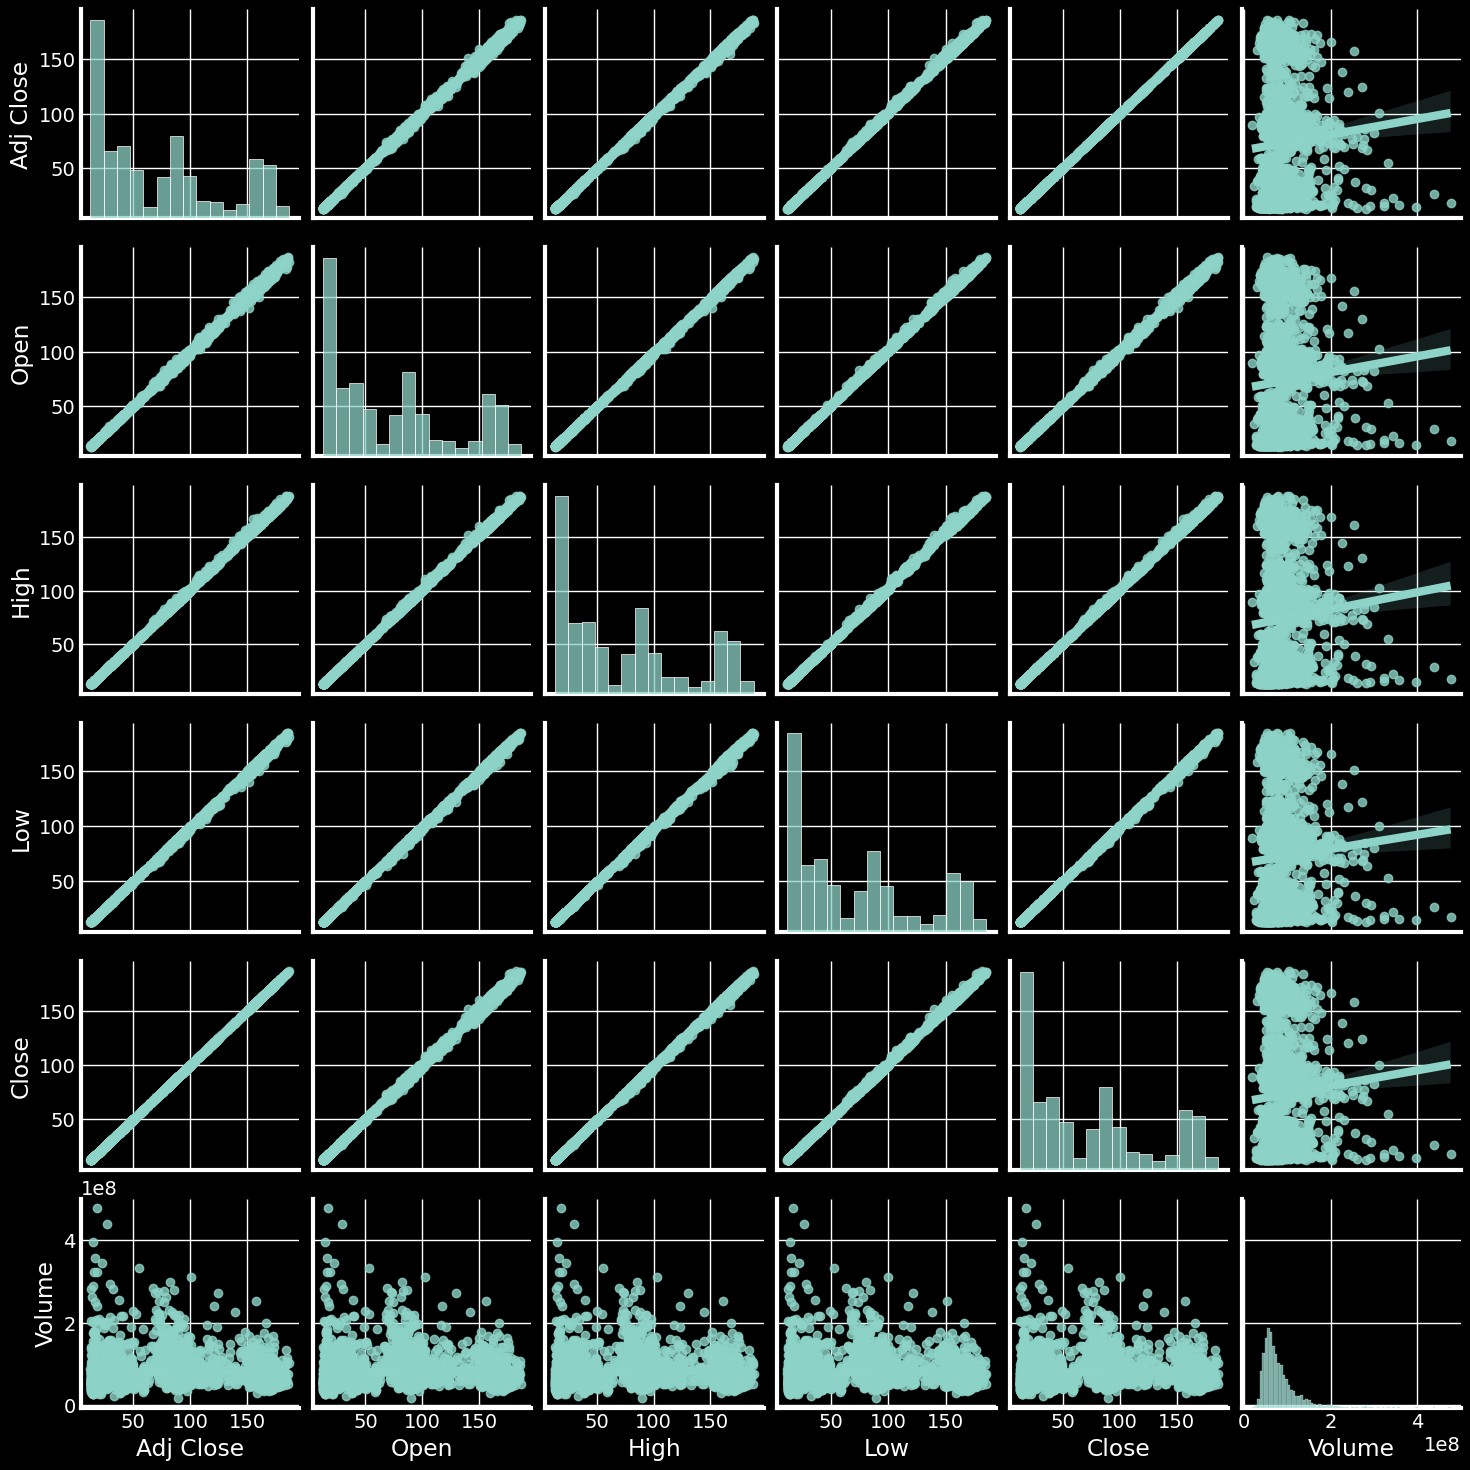

In [133]:
sns.pairplot(data.drop('Date', axis =1), kind='reg');

### **Correlation Plot**

In [134]:
fig = px.imshow(data.corr(), template = 'plotly_dark')
fig.show()

<ipython-input-134-33a0ee481aef>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



**From the above figure we can see that except volume all columns are highly correlated with each other.**

### **Box Plot**

In [135]:
fig = px.box(data,x=['Open', 'High', 'Low', 'Close', 'Adj Close'], template = 'plotly_dark', 
             title = 'Outliers')
fig.show()

In [136]:
fig = px.box(data,x=['Volume'], template = 'plotly_dark', 
             title = 'Outliers')
fig.show()

### **3D - Scatter Plot**

In [137]:
fig = px.scatter_3d(data, x='High', y='Low', z='Close',
              color='Adj Close', template = 'plotly_dark', title = 'Distribution of Highs, Lows and Closing Values represented by Adj Close')
fig.show()

### **Resampling and Rolling**

Resampling is very common in time-series data. Most of the time resampling is done to a lower frequency.Though resampling of higher frequency is also necessary especially for modeling purposes. Not so much in data analysis purpose. In the ‘Volume’ data we are working on right now, we can observe some big spikes here and there. These types of spikes are not helpful for data analysis or for modeling. normally to smooth out the spikes, resampling to a lower frequency and rolling is very helpful.

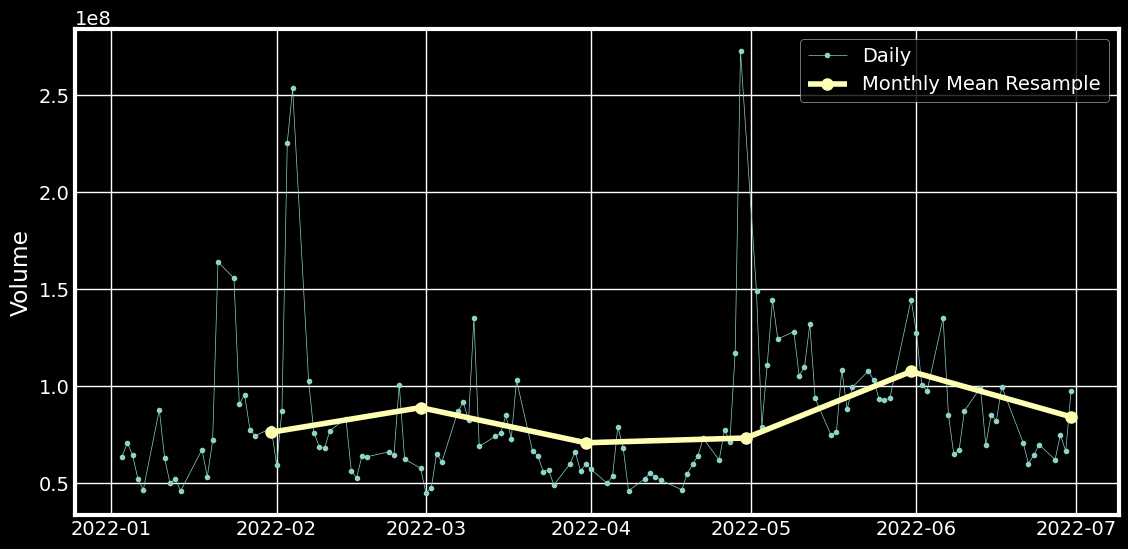

In [142]:
df_month = all_data.resample("M").mean()
start, end = '2022-01', '2022-06'
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(all_data.loc[start:end, 'Volume'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(df_month.loc[start:end, 'Volume'],
marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Volume')
ax.legend();

#### **Week Resample**

In [143]:
df_week = all_data.resample("W").mean()

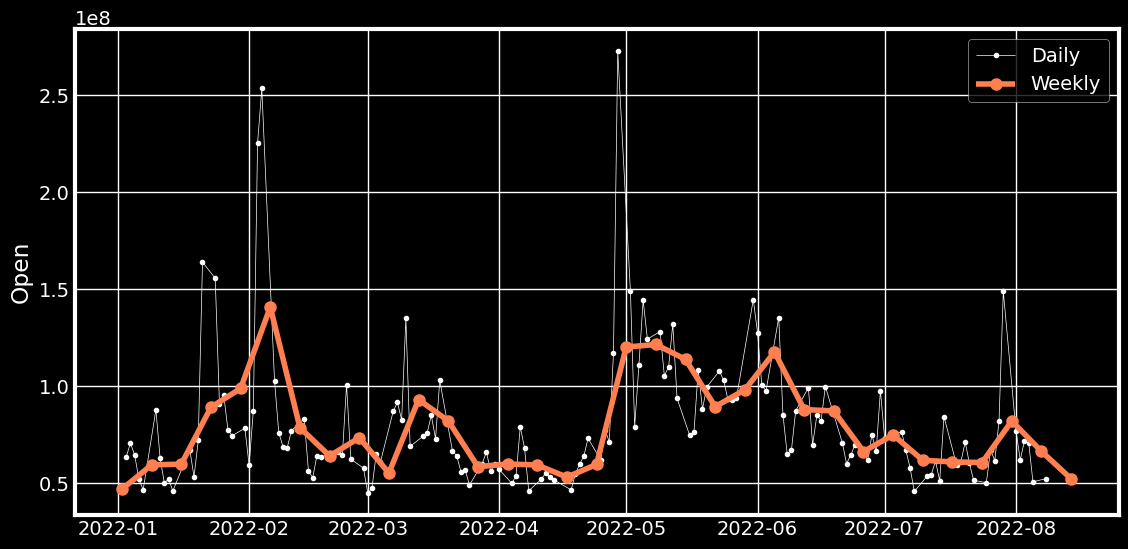

In [144]:
start, end = '2022-01', '2022-08'
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(all_data.loc[start:end, 'Volume'], marker='.', linestyle='-', linewidth = 0.5, label='Daily', color='white')
ax.plot(df_week.loc[start:end, 'Volume'], marker='o', markersize=8, linestyle='-', label='Weekly', color='coral')
ax.set_ylabel("Open")
ax.legend()

#### **Rolling**

Rolling is another very helpful way of smoothing out the curve. It takes the average of a specified amount of data. If I want a 7-day rolling, it gives us the 7-day average data.

We are doing it on the above plot

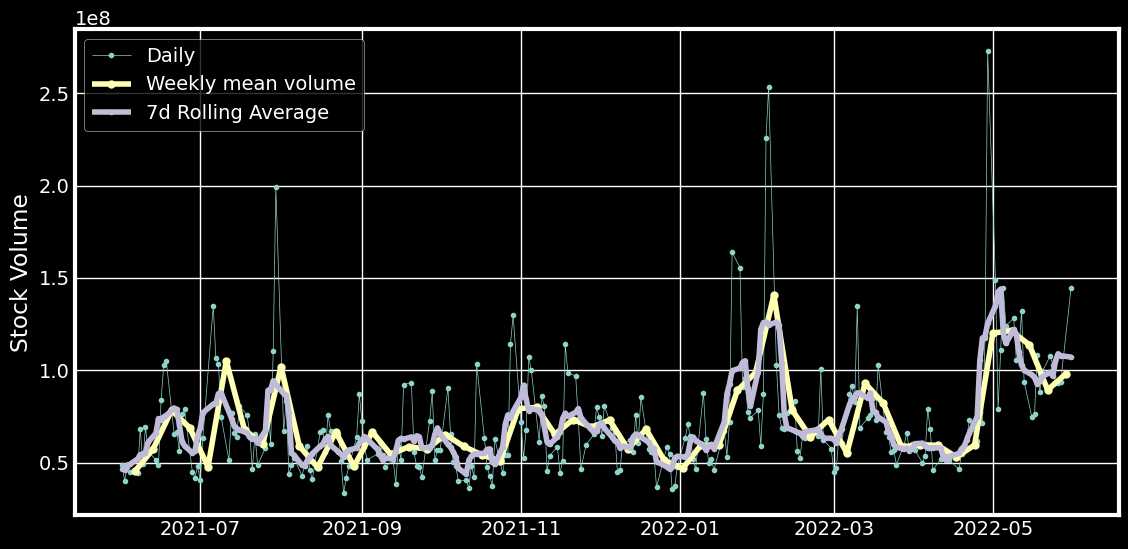

In [145]:
df_7d_rolling = all_data.rolling(7, center=True).mean()
start, end = '2021-06', '2022-05'
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(all_data.loc[start:end, 'Volume'], marker='.', linestyle='-', 
        linewidth=0.5, label='Daily')
ax.plot(df_week.loc[start:end, 'Volume'], marker='o', markersize=5, 
        linestyle='-', label = 'Weekly mean volume')
ax.plot(df_7d_rolling.loc[start:end, 'Volume'], marker='.', linestyle='-', label='7d Rolling Average')
ax.set_ylabel('Stock Volume')
ax.legend()

7-d rolling average is a bit smoother than the weekly average.

### **Differencing**

Differencing takes the difference in values of a specified distance.It is a popular method to remove the trend in the data. The trend is not good for forecasting or modeling.

I've used expanding window,an another way of transformation. It keeps adding the cumulative. For example, if you add an expanding function to the ‘High’ column first element remains the same. The second element becomes cumulative of the first and second element, the third element becomes cumulative of the first, second, and third element, and so on. You can use aggregate functions like mean, median, standard deviation, etc. on it too

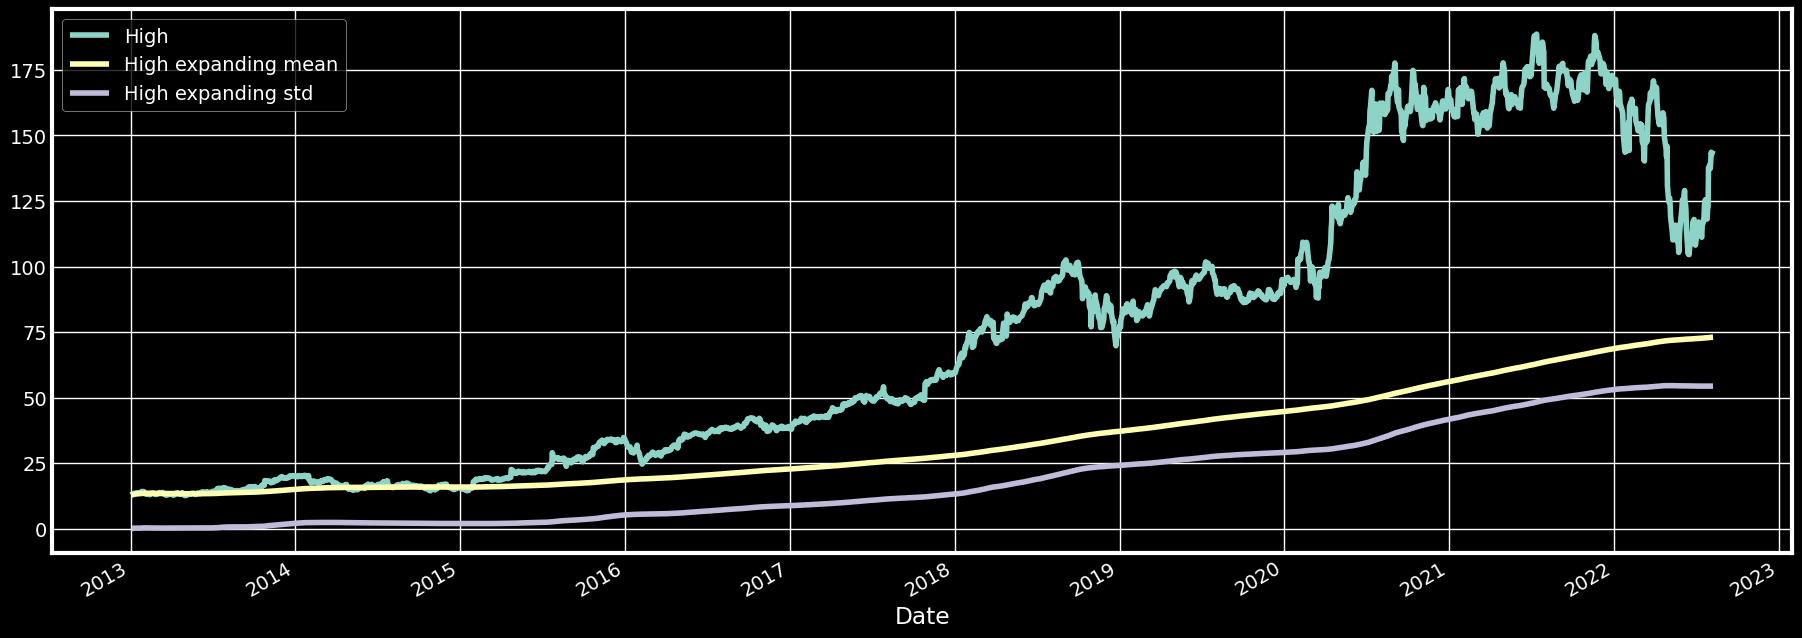

In [146]:
fig, ax = plt.subplots(figsize=(20, 8))
ax = all_data.High.plot(label='High')
ax = all_data.High.expanding().mean().plot(label='High expanding mean')
ax = all_data.High.expanding().std().plot(label='High expanding std')
ax.legend()

### **Plotting The Change**

#### **Shift**

The shift function shifts the data before or after the specified amount of time. It will shift the data by one day by default. That means you will get the previous day's data. In financial data like this one, it is helpful to see previous day data and today's data side by side.

In [147]:
df = all_data

<Axes: xlabel='Date'>

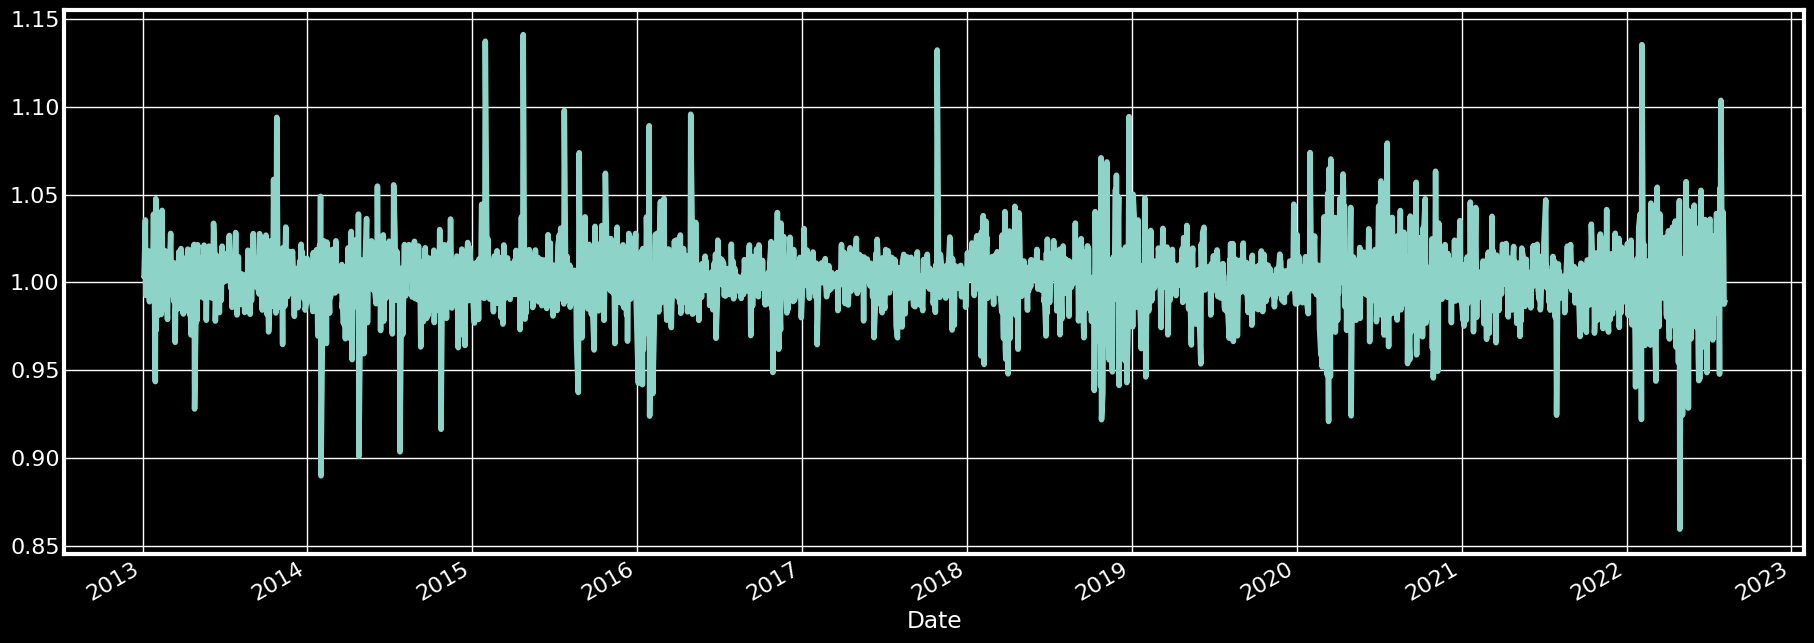

In [148]:
df['Change'] = df.Close.div(df.Close.shift())
df['Change'].plot(figsize=(20, 8), fontsize = 16)

In the code above, .div() helps to fill up the missing data. Actually, div() means division. df. div(6) will divide each element in df by 6. But here I used ‘df.Close.shift()’. So, Each element of df will be divided by each element of ‘df.Close.shift()’. We do this to avoid the null values that are created by the ‘shift()’ operation.

### **Heat Map**

In [149]:
corr = df.corr()

corr.style.background_gradient(cmap='coolwarm')

# **Preprocessing**

In [150]:
print("There are "+ str(all_data[:'2020'].shape[0]) + " observations in the training data")
print("There are "+ str(all_data['2021':].shape[0]) + " observations in the test data")

There are 2015 observations in the training data
There are 402 observations in the test data


In [151]:
def ts_train_test(all_data,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2020/12/31
      X_test:  data from 2021 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    ts_train = all_data[:'2020'].iloc[:,0:1].values
    ts_test  = all_data['2021':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train[i-time_steps:i,0])
        y_train.append(ts_train[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2020'], all_data["Adj Close"]['2021':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test

X_train, y_train, X_test = ts_train_test(all_data,5,2)
X_train.shape[0],X_train.shape[1]

(2009, 5)

In [152]:
# Make the 3-D shape to a data frame so we can see: 
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see,y_train_see],axis=1)

0       1       2       3       4       0       1
0      12.87   12.92   12.96   13.42   13.32   13.32   13.27
1      12.92   12.96   13.42   13.32   13.32   13.27   13.40
2      12.96   13.42   13.32   13.32   13.27   13.40   13.64
3      13.42   13.32   13.32   13.27   13.40   13.64   13.60
4      13.32   13.32   13.27   13.40   13.64   13.60   13.45
...      ...     ...     ...     ...     ...     ...     ...
2004  162.05  161.80  160.08  160.31  160.33  159.26  158.63
2005  161.80  160.08  160.31  160.33  159.26  158.63  164.20
2006  160.08  160.31  160.33  159.26  158.63  164.20  166.10
2007  160.31  160.33  159.26  158.63  164.20  166.10  164.29
2008  160.33  159.26  158.63  164.20  166.10  164.29  162.85

[2009 rows x 7 columns]

In [153]:
# Make the 3-D shape to a data frame so we can see: 
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))
pd.DataFrame(X_test_see)

0       1       2       3       4
0    158.63  164.20  166.10  164.29  162.85
1    164.20  166.10  164.29  162.85  159.33
2    166.10  164.29  162.85  159.33  160.93
3    164.29  162.85  159.33  160.93  156.92
4    162.85  159.33  160.93  156.92  158.11
..      ...     ...     ...     ...     ...
395  122.42  121.14  114.81  120.97  122.28
396  121.14  114.81  120.97  122.28  134.95
397  114.81  120.97  122.28  134.95  135.39
398  120.97  122.28  134.95  135.39  134.16
399  122.28  134.95  135.39  134.16  139.52

[400 rows x 5 columns]

In [154]:
print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 2009 samples in the training data
There are 400 samples in the test data


# **Model Building**

## **Simple RNN**

In [155]:
def simple_rnn_model(X_train, y_train, X_test):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN
    
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # The time step of the output

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=0)

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)

    return my_rnn_model, rnn_predictions

my_rnn_model, rnn_predictions = simple_rnn_model(X_train, y_train, X_test)
rnn_predictions[1:10]

13/13 [==============================] - 1s 6ms/step


array([[51.45734 , 48.8357  ],
       [51.45734 , 48.8357  ],
       [51.45734 , 48.8357  ],
       [51.45734 , 48.8357  ],
       [51.45734 , 48.8357  ],
       [51.45734 , 48.835697],
       [51.45734 , 48.835697],
       [51.45734 , 48.8357  ],
       [51.45734 , 48.835697]], dtype=float32)

(11331.816, <Axes: xlabel='Date'>)

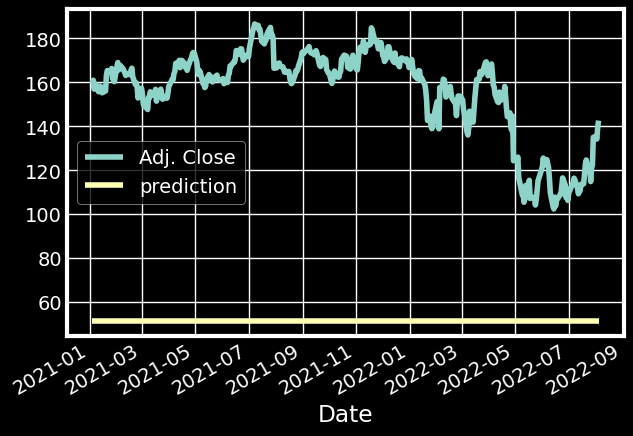

In [156]:
def actual_pred_plot(preds):
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = all_data.loc['2021':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']),np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot() )
    
actual_pred_plot(rnn_predictions)  

13/13 [==============================] - 0s 4ms/step


(127.86447, <Axes: xlabel='Date'>)

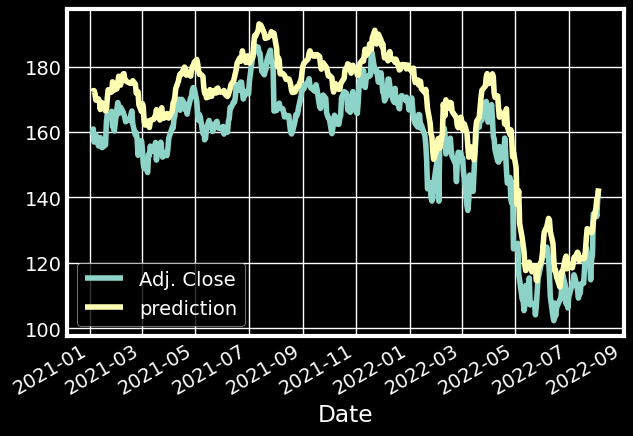

In [157]:
def ts_train_test_normalize(all_data,time_steps,for_periods):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2020/12/31
      X_test:  data from 2021 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    ts_train = all_data[:'2020'].iloc[:,0:1].values
    ts_test  = all_data['2021':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1): 
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Adj Close"][:'2020'], all_data["Adj Close"]['2021':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])
        
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

def simple_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN
    
    my_rnn_model = Sequential()
    my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    #my_rnn_model.add(SimpleRNN(32, return_sequences=True))
    my_rnn_model.add(SimpleRNN(32))
    my_rnn_model.add(Dense(2)) # The time step of the output

    my_rnn_model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    my_rnn_model.fit(X_train, y_train, epochs=100, batch_size=150, verbose=0)

    # Finalizing predictions
    rnn_predictions = my_rnn_model.predict(X_test)
    from sklearn.preprocessing import MinMaxScaler
    rnn_predictions = sc.inverse_transform(rnn_predictions)

    return my_rnn_model, rnn_predictions


X_train, y_train, X_test, sc = ts_train_test_normalize(all_data,5,2)
my_rnn_model, rnn_predictions_2 = simple_rnn_model(X_train, y_train, X_test, sc)
rnn_predictions_2[1:10]
actual_pred_plot(rnn_predictions_2)   

## **Simple LSTM**

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



14/14 [==============================] - 6s 20ms/step - loss: 0.0907
Epoch 2/50
14/14 [==============================] - 0s 19ms/step - loss: 0.0626
Epoch 3/50
14/14 [==============================] - 0s 19ms/step - loss: 0.0544
Epoch 4/50
14/14 [==============================] - 0s 20ms/step - loss: 0.0500
Epoch 5/50
14/14 [==============================] - 0s 20ms/step - loss: 0.0455
Epoch 6/50
14/14 [==============================] - 0s 20ms/step - loss: 0.0411
Epoch 7/50
14/14 [==============================] - 0s 20ms/step - loss: 0.0368
Epoch 8/50
14/14 [==============================] - 0s 21ms/step - loss: 0.0322
Epoch 9/50
14/14 [==============================] - 0s 20ms/step - loss: 0.0274
Epoch 10/50
14/14 [==============================] - 0s 19ms/step - loss: 0.0227
Epoch 11/50
14/14 [==============================] - 0s 19ms/step - loss: 0.0180
Epoch 12/50
14/14 [==============================] - 0s 23ms/step - loss: 0.0137
Epoch 13/50
14/14 [=============================

(49.389355, <Axes: xlabel='Date'>)

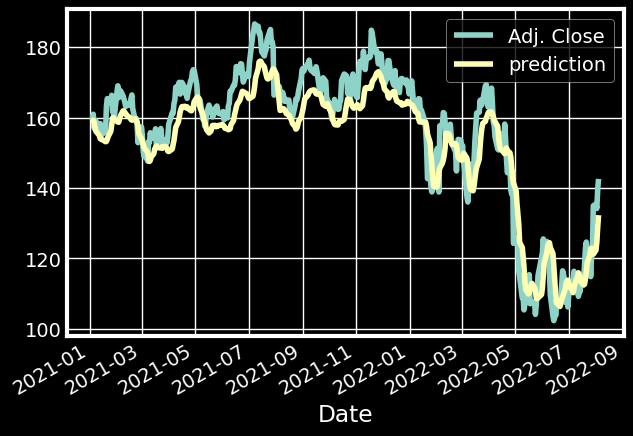

In [158]:
def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers.legacy import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=1)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)   

## **Simple GRU**

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



14/14 [==============================] - 5s 22ms/step - loss: 0.1025
Epoch 2/50
14/14 [==============================] - 0s 24ms/step - loss: 0.0599
Epoch 3/50
14/14 [==============================] - 0s 23ms/step - loss: 0.0389
Epoch 4/50
14/14 [==============================] - 0s 22ms/step - loss: 0.0254
Epoch 5/50
14/14 [==============================] - 0s 23ms/step - loss: 0.0149
Epoch 6/50
14/14 [==============================] - 0s 23ms/step - loss: 0.0077
Epoch 7/50
14/14 [==============================] - 0s 16ms/step - loss: 0.0034
Epoch 8/50
14/14 [==============================] - 0s 14ms/step - loss: 0.0014
Epoch 9/50
14/14 [==============================] - 0s 15ms/step - loss: 5.8253e-04
Epoch 10/50
14/14 [==============================] - 0s 14ms/step - loss: 3.1595e-04
Epoch 11/50
14/14 [==============================] - 0s 14ms/step - loss: 2.2476e-04
Epoch 12/50
14/14 [==============================] - 0s 15ms/step - loss: 1.9290e-04
Epoch 13/50
14/14 [=============

(25.526451, <Axes: xlabel='Date'>)

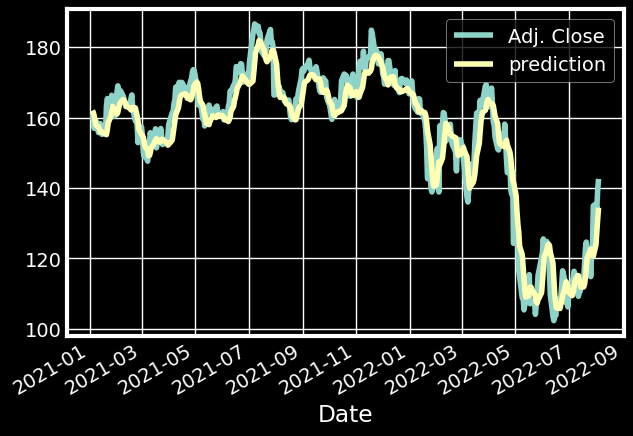

In [159]:
def GRU_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU
    from tensorflow.keras.optimizers.legacy import SGD
    
    # The GRU architecture
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(GRU(units=50, activation='tanh'))
    my_GRU_model.add(Dense(units=2))

    # Compiling the RNN
    my_GRU_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_GRU_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=1)

    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)

    return my_GRU_model, GRU_prediction

my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)  

In [160]:
GRU_prediction[1:10]

array([[161.45468, 161.77026],
       [160.57024, 160.86302],
       [158.96385, 159.25418],
       [157.85706, 158.1376 ],
       [157.3757 , 157.65361],
       [156.70392, 156.98468],
       [155.8965 , 156.17738],
       [156.0258 , 156.29353],
       [155.80939, 156.08162]], dtype=float32)

## **Stacked LSTM**

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



14/14 [==============================] - 9s 29ms/step - loss: 0.0933
Epoch 2/50
14/14 [==============================] - 0s 28ms/step - loss: 0.0694
Epoch 3/50
14/14 [==============================] - 0s 32ms/step - loss: 0.0636
Epoch 4/50
14/14 [==============================] - 0s 29ms/step - loss: 0.0624
Epoch 5/50
14/14 [==============================] - 0s 31ms/step - loss: 0.0611
Epoch 6/50
14/14 [==============================] - 0s 29ms/step - loss: 0.0602
Epoch 7/50
14/14 [==============================] - 0s 29ms/step - loss: 0.0590
Epoch 8/50
14/14 [==============================] - 0s 29ms/step - loss: 0.0579
Epoch 9/50
14/14 [==============================] - 0s 30ms/step - loss: 0.0566
Epoch 10/50
14/14 [==============================] - 0s 30ms/step - loss: 0.0552
Epoch 11/50
14/14 [==============================] - 0s 30ms/step - loss: 0.0537
Epoch 12/50
14/14 [==============================] - 0s 31ms/step - loss: 0.0519
Epoch 13/50
14/14 [=============================

(65.84842, <Axes: xlabel='Date'>)

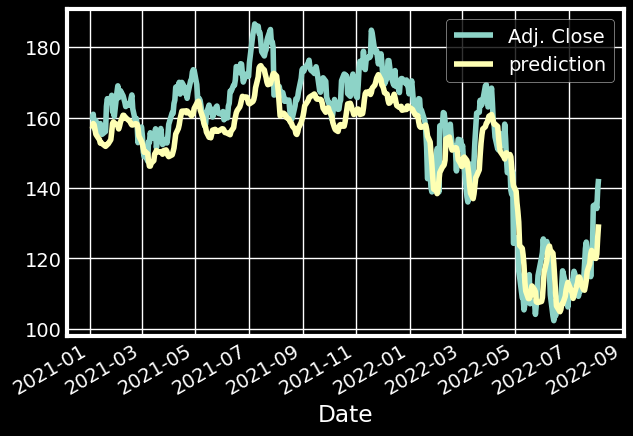

In [161]:
def LSTM_model_regularization(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout
    from tensorflow.keras.optimizers.legacy  import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    # my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh'))
    my_LSTM_model.add(Dropout(0.2))
    my_LSTM_model.add(Dense(units=2))

    # Compiling
    my_LSTM_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=1)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

my_LSTM_model, LSTM_prediction = LSTM_model_regularization(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)  

## **Stacked GRU**

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



14/14 [==============================] - 11s 30ms/step - loss: 0.0831
Epoch 2/50
14/14 [==============================] - 0s 30ms/step - loss: 0.0666
Epoch 3/50
14/14 [==============================] - 0s 30ms/step - loss: 0.0573
Epoch 4/50
14/14 [==============================] - 0s 31ms/step - loss: 0.0530
Epoch 5/50
14/14 [==============================] - 0s 30ms/step - loss: 0.0479
Epoch 6/50
14/14 [==============================] - 0s 31ms/step - loss: 0.0421
Epoch 7/50
14/14 [==============================] - 0s 31ms/step - loss: 0.0344
Epoch 8/50
14/14 [==============================] - 0s 30ms/step - loss: 0.0252
Epoch 9/50
14/14 [==============================] - 0s 30ms/step - loss: 0.0160
Epoch 10/50
14/14 [==============================] - 0s 31ms/step - loss: 0.0086
Epoch 11/50
14/14 [==============================] - 0s 31ms/step - loss: 0.0044
Epoch 12/50
14/14 [==============================] - 0s 30ms/step - loss: 0.0030
Epoch 13/50
14/14 [============================

(25.526451, <Axes: xlabel='Date'>)

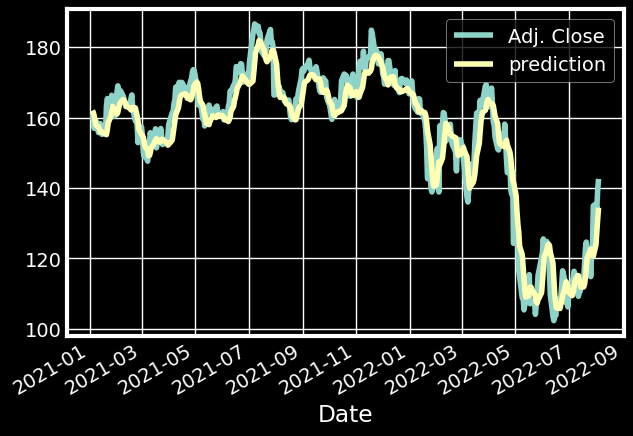

In [162]:
def GRU_model_regularization(X_train, y_train, X_test, sc):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU
    from tensorflow.keras.optimizers.legacy  import SGD
    from keras.layers import Dropout
    
    # The GRU architecture
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Second GRU layer
    my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    
    # Third GRU layer
    my_GRU_model.add(GRU(units=50, return_sequences=True, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # Fourth GRU layer
    my_GRU_model.add(GRU(units=50, activation='tanh'))
    my_GRU_model.add(Dropout(0.2))
    # The output layer
    my_GRU_model.add(Dense(units=2))
    # Compiling the RNN
    my_GRU_model.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
    # Fitting to the training set
    my_GRU_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=1)

    GRU_predictions = my_GRU_model.predict(X_test)
    GRU_predictions = sc.inverse_transform(GRU_predictions)

    return my_GRU_model, GRU_predictions

my_GRU_model, GRU_predictions = GRU_model_regularization(X_train, y_train, X_test, sc)
GRU_predictions[1:10]
actual_pred_plot(GRU_prediction)  

# **Sentiment analysis**

## Installing and importing dependencies

To fetch tweets from twitter, we need to install the tweepy library. We will be using this package to pull tweets on which our model will make predictions.

In [163]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
import tweepy as tw #for accessing Twitter API


#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Exploratory Data Analysis

### Cleaning and prepping dataset

In [164]:
# Load Tweet dataset
df = pd.read_csv('stock_sentiment_data.csv', encoding = 'latin1')
# Random 500 data from dataset
# df = df.sample(500)
df = df.rename(columns={'Text': 'clean_text', 'Sentiment':'category'})
df['category'] = df['category'].map({-1: -1.0, 1:1.0})
# Output first five rows
df.head()

clean_text  category
0  Kickers on my watchlist XIDE TIT SOQ PNK CPW B...       1.0
1  user: AAP MOVIE. 55% return for the FEA/GEED i...       1.0
2  user I'd be afraid to short AMZN - they are lo...       1.0
3                                  MNTA Over 12.00         1.0
4                                   OI  Over 21.37         1.0

The `category` column has 3 values:
1. 0.0 Indicating it is a Neutral Sentiment
2. 1.0 Indicating a Postive Sentiment
3. -1.0 Indicating a Negative Sentiment

In [165]:
# Check for missing data
df.isnull().sum()

clean_text    0
category      0
dtype: int64

In [166]:
# drop missing rows
df.dropna(axis=0, inplace=True)

In [167]:
# dimensionality of the data
df.shape

(5791, 2)

In [168]:
# Map tweet categories
df['category'] = df['category'].map({-1.0:'Negative', 1.0:'Positive'})

# Output first five rows
df.head()

clean_text  category
0  Kickers on my watchlist XIDE TIT SOQ PNK CPW B...  Positive
1  user: AAP MOVIE. 55% return for the FEA/GEED i...  Positive
2  user I'd be afraid to short AMZN - they are lo...  Positive
3                                  MNTA Over 12.00    Positive
4                                   OI  Over 21.37    Positive

## Exploratory Data Analysis

Data Visualisation-

In [169]:
# The distribution of sentiments
df.groupby('category').count().plot(kind='bar')

Plotting the distribution of tweet lengths

In [170]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['clean_text']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

Plotting the distribution of text length for positive sentiment tweets

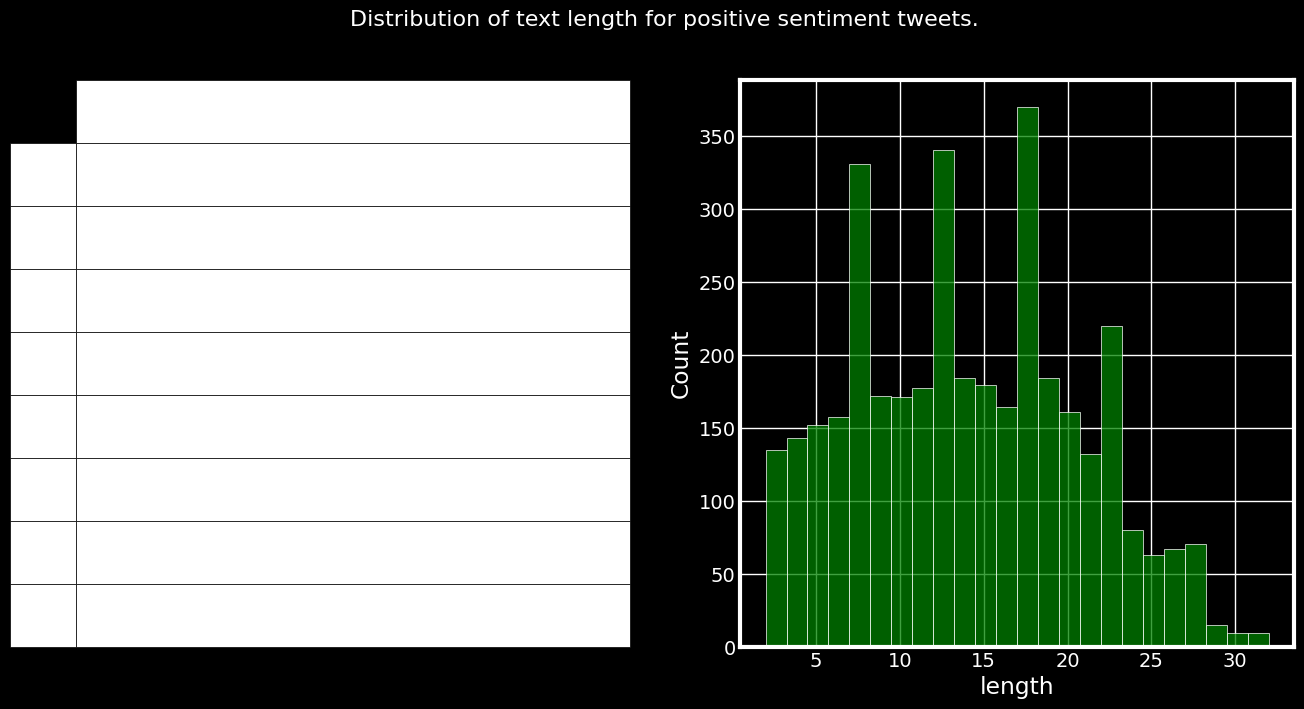

In [171]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Positive']['length'], ax=ax1,color='green')
describe = df.length[df.category=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

Plotting the Distribution of text length for Negative sentiment tweets.

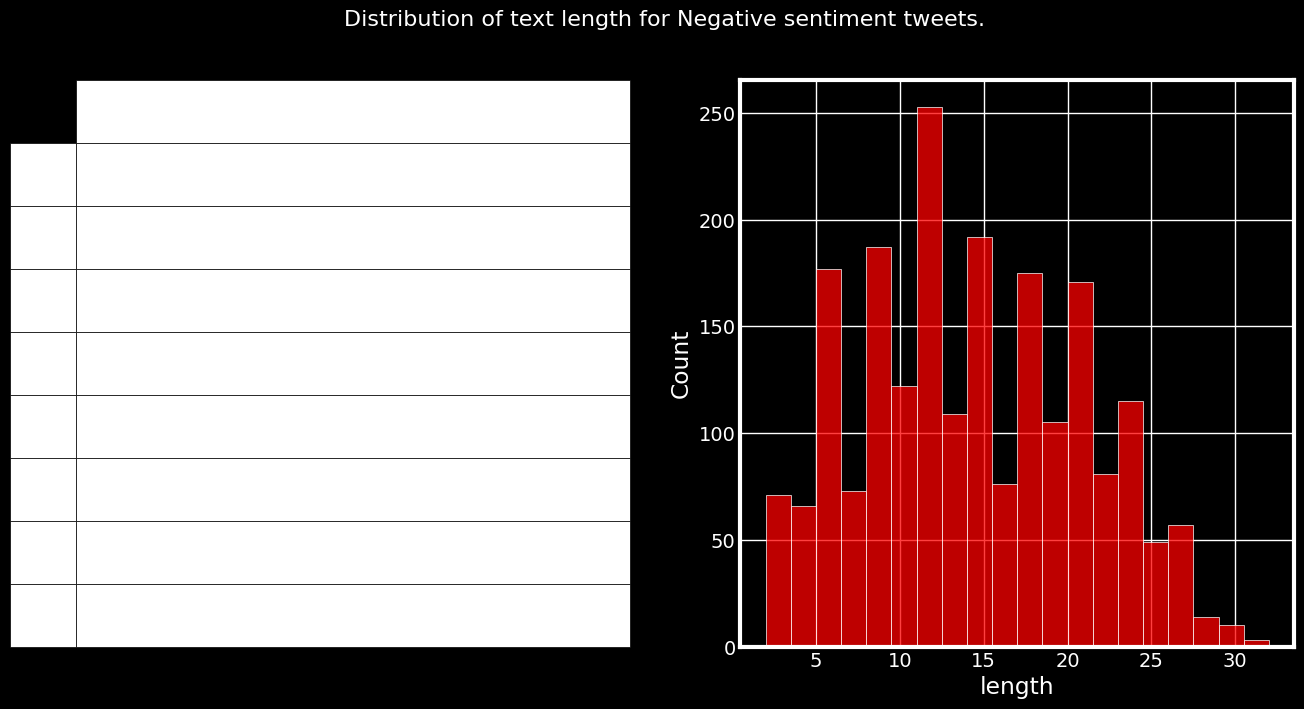

In [172]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Negative']['length'], ax=ax1,color='red')
describe = df.length[df.category=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment tweets.', fontsize=16)

plt.show()

Plotting the Pie chart of the percentage of different sentiments of all the tweets

In [173]:
import plotly.express as px
fig = px.pie(df, names='category', title ='Pie chart of different sentiments of tweets')
fig.show()

In [174]:
df.drop(['length'], axis=1, inplace=True)
df.head()

clean_text  category
0  Kickers on my watchlist XIDE TIT SOQ PNK CPW B...  Positive
1  user: AAP MOVIE. 55% return for the FEA/GEED i...  Positive
2  user I'd be afraid to short AMZN - they are lo...  Positive
3                                  MNTA Over 12.00    Positive
4                                   OI  Over 21.37    Positive

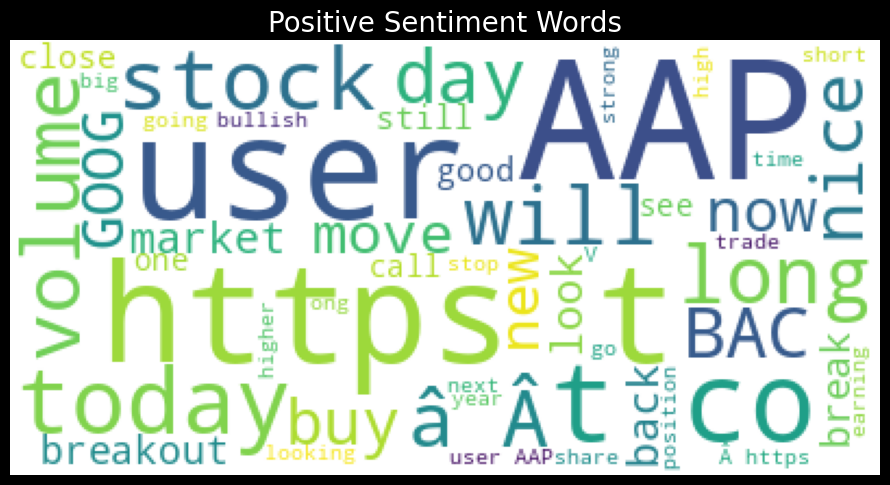

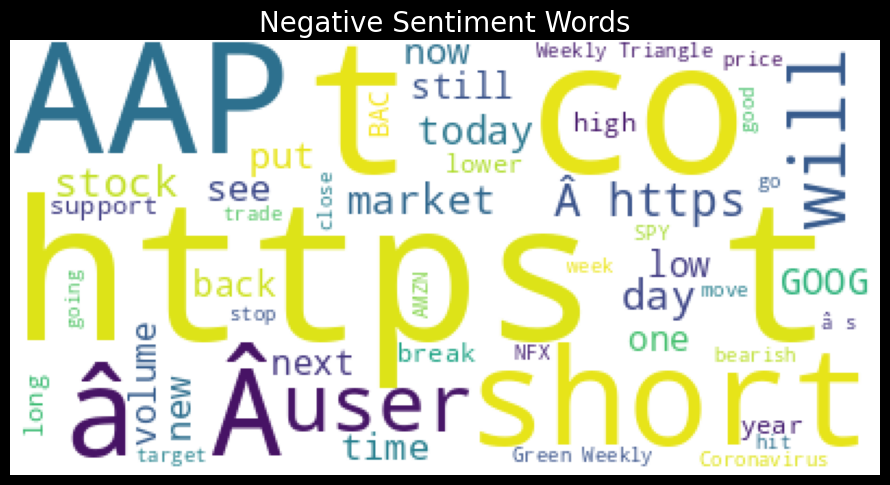

In [175]:
#### Visualizing data into wordclouds


from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset
       - category: Positive/Negative
    '''
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.category==category]['clean_text']])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()
    
# Positive tweet words
wordcount_gen(df, 'Positive')
     
# Negative tweet words
wordcount_gen(df, 'Negative')

     


## Data Preprocessing

In [176]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''
    
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", tweet_to_words(df['clean_text'][0]))


Original tweet -> Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ  trade method 1 or method 2, see prev posts

Processed tweet -> ['kicker', 'watchlist', 'xide', 'tit', 'soq', 'pnk', 'cpw', 'bpz', 'aj', 'trade', 'method', '1', 'method', '2', 'see', 'prev', 'post']


In [177]:
# Apply data processing to each tweet
X = list(map(tweet_to_words, df['clean_text']))

In [178]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['category'])

In [179]:
print(X[0])
print(Y[0])

['kicker', 'watchlist', 'xide', 'tit', 'soq', 'pnk', 'cpw', 'bpz', 'aj', 'trade', 'method', '1', 'method', '2', 'see', 'prev', 'post']
1


### Train and test split

In [180]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

### Bag of words (BOW) feature extraction

In [181]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

vocabulary_size = 5000

# Tweets have already been preprocessed hence dummy function will be passed in 
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



### Tokenizing & Padding

In [182]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ  trade method 1 or method 2, see prev posts
After Tokenization & Padding 
 [4613    4   48  443 3254 4614 4615 4616 3255 4617 1453   89 3256   27
   87 3256   32   79 2147 2562    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


### Saving tokenized data

In [183]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

### Train & Test Split

In [184]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (3474, 50) (3474, 2)
Validation Set -> (1158, 50) (1158, 2)
Test Set -> (1159, 50) (1159, 2)


In [185]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Bidirectional LSTM Using NN

In [186]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

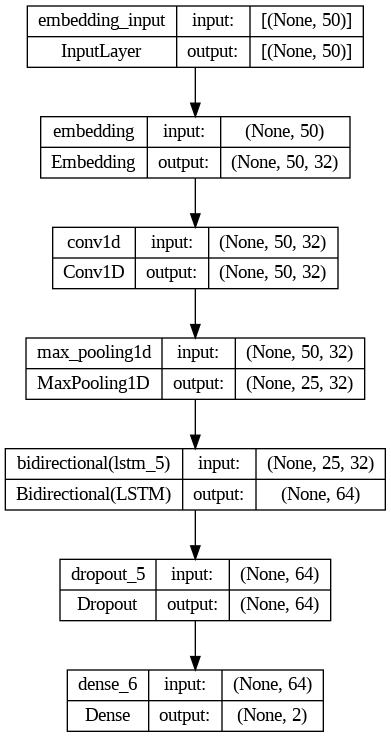

In [187]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [188]:
print(model.summary())
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            160000    
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 32)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 2)                

### Model Accuracy & Loss

In [189]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.6790
Precision : 0.6790
Recall    : 0.6790
F1 Score  : 0.6790


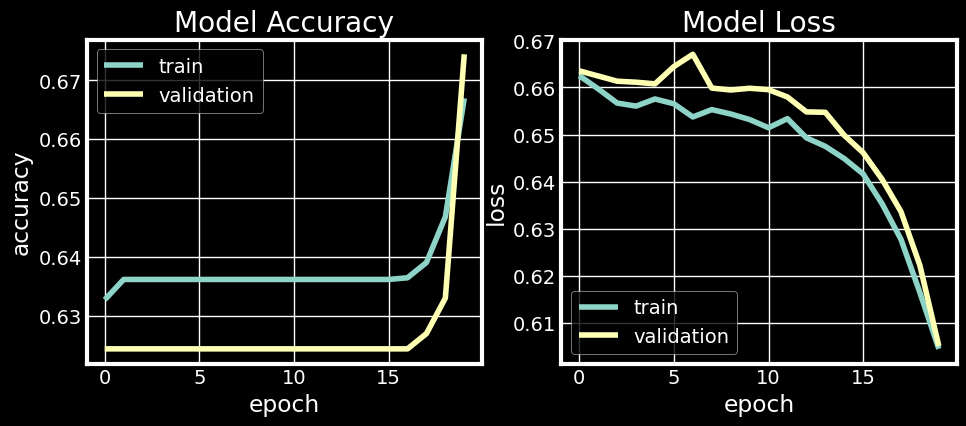

In [190]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

### Model Confusion Matrix

37/37 [==============================] - 1s 8ms/step


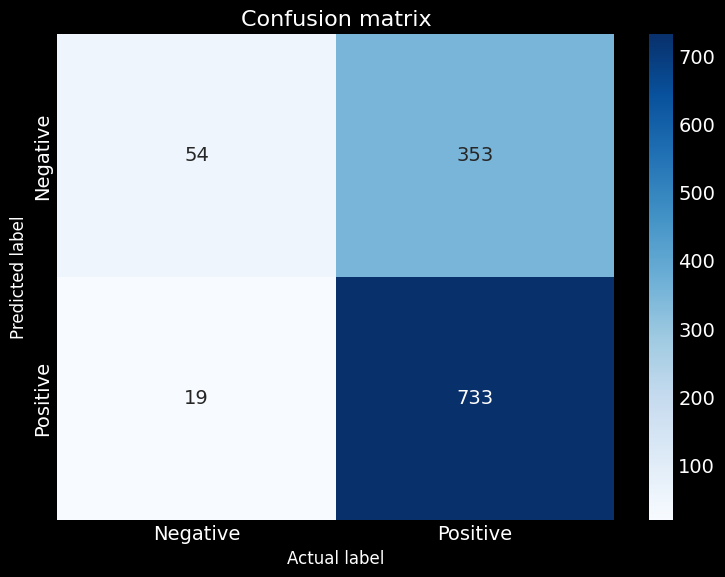

In [191]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

### Model save and load for the prediction

In [192]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

Best model saved


In [193]:
from keras.models import load_model

# Load model
model = load_model('best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Positive']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [194]:
predict_class(['The stock is going rock'])

1/1 [==============================] - 1s 858ms/step
The predicted sentiment is Positive


# **Decision Tree Classifier**

In [195]:
# building the decision tree classifier
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
# accuracy of the model 
from sklearn.metrics import accuracy_score,classification_report
dt_acc = accuracy_score(y_test, y_pred)
print("The accuracy obtrained by the Decision Tree Classifier is: ",dt_acc)

The accuracy obtrained by the Decision Tree Classifier is:  0.5832614322691976


In [196]:
# print the classificatin report 
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.41      0.45      0.43       407
           1       0.69      0.66      0.67       752

   micro avg       0.58      0.58      0.58      1159
   macro avg       0.55      0.55      0.55      1159
weighted avg       0.59      0.58      0.59      1159
 samples avg       0.58      0.58      0.58      1159



# **Random FOrest Classifier**

In [197]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
# predict on test data
y_pred = rf.predict(X_test)
# accuracy of the model
rf_acc = accuracy_score(y_test, y_pred)
print("The accuracy obtrained by the Random Forest Classifier is: ",rf_acc)

The accuracy obtrained by the Random Forest Classifier is:  0.6635030198446937


In [198]:
# print the classificatin report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.61      0.22      0.33       407
           1       0.69      0.90      0.78       752

   micro avg       0.68      0.66      0.67      1159
   macro avg       0.65      0.56      0.55      1159
weighted avg       0.66      0.66      0.62      1159
 samples avg       0.66      0.66      0.66      1159



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



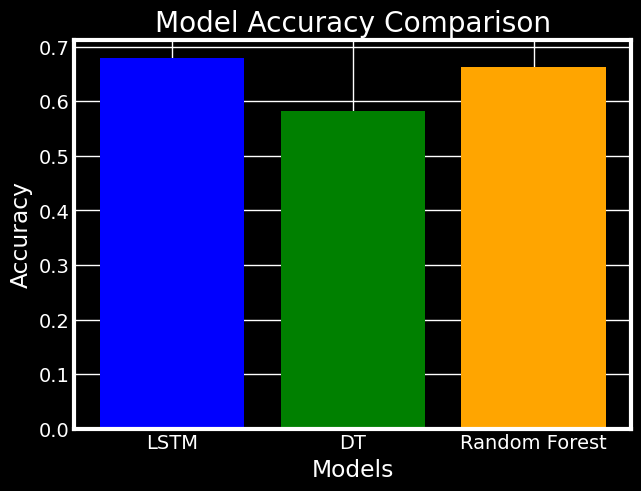

In [199]:
import numpy as np
import matplotlib.pyplot as plt

# Accuracy values of the models
lstm_acc = accuracy
dt_acc = dt_acc
rf_acc = rf_acc

# Create a bar plot
fig, ax = plt.subplots()
models = ('LSTM', 'DT', 'Random Forest')
acc = np.array([lstm_acc, dt_acc, rf_acc])
colors = ['blue', 'green', 'orange']
ax.bar(models, acc, color=colors)

# Set plot title and labels
ax.set_title('Model Accuracy Comparison')
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')

# Show plot
plt.show()